<a href="https://colab.research.google.com/github/sdgroeve/D012554_Machine_Learning_2023/blob/main/02_neural_networks_in_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
import requests
from pathlib import Path 

request = requests.get("https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/utils/utils.py")
with open("utils.py", "wb") as f:
  f.write(request.content)

from utils import plot_decision_boundary

In [2]:
#@title
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. Neural networks in PyTorch


In [1]:
import torch
from torch import nn 

torch.manual_seed(46)

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

## Preparing the data

The dataset for this notebook is in a flat file called `dataset_neural_networks.csv`. 

We read this file into a Pandas DataFrame.

In [3]:
from torch.utils.data import Dataset

class XORDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self):
        # load data
        fn = "https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/datasets/dataset_neural_networks.csv"
        self.df=pd.read_csv(fn)
        # extract labels
        self.df_labels=df[['y']]
        self.df.pop('y')
        # conver to torch dtypes
        self.dataset=torch.tensor(self.df.to_numpy())
        self.labels=torch.tensor(self.df_labels.to_numpy().reshape(-1))
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.dataset)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

In [7]:
import torch.utils.data as data
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class XORDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 32):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage: str):
        self.data = XORDataset()

        # Random split
        self.train_set_size = int(len(self.data) * 0.8)
        self.valid_set_size = len(self.data) - self.train_set_size
        self.train_set, self.valid_set = data.random_split(self.data, [self.train_set_size, self.valid_set_size])

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.valid_set, batch_size=self.batch_size)

## Building the model

We increase the complexity of our model by adding an additional linear layer to the **model architecture**.   

In [6]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.2 MB/s eta 0:00:00


In [8]:
import pytorch_lightning as pl

class NeuralNetwork(pl.LightningModule):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        num_neurons_layer_2 = 6

        self.layer_1 = nn.Linear(in_features=input_dim, out_features=num_neurons_layer_2)
        self.layer_2 = nn.Linear(in_features=num_neurons_layer_2, out_features=output_dim)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.layer_2(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.BCEWithLogitsLoss(y_hat, y)
        return loss    

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = torch.nn.BCEWithLogitsLoss(y_hat, y)
        print("val_loss = %f"%val_loss)

### `__init()__`

Our neural network has two linear layers. The first layer `layer_1` has `input_dim` (the number of features in our dataset) input features that form the **input layer**. It has `num_neurons_layer_2` output features that form the **hidden layer** where these features are typically called **hidden neurons**.

The second layer `layer_2` has `num_neurons_layer_2` input features (neurons) and `output_dim` (which equals to 1 for two-class classification) output features, the **output layer**.

An example of this model architecture with `num_neurons_layer_2 = 6` can be seen [here](https://playground.tensorflow.org/#activation=sigmoid&batchSize=30&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=6&seed=0.86658&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

We will use the Rectified Linear Unit (ReLU) activation function in the hidden layer. In the output layer we use the sigmoid function (through `BCEWithLogitsLoss`, so we not to explicitly apply the sigmoid function during inference (see notebook about logistic regression)).

Next, we create an instance of the class `NeuralNetwork`.

In [9]:
# Two inputs x_1 and x_2
input_dim = 2  
# Single binary output 
output_dim = 1 

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = NeuralNetwork(input_dim, output_dim)

model.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.2278, -0.6223],
                      [ 0.0246, -0.4814],
                      [ 0.3607,  0.4794],
                      [-0.6118, -0.0522],
                      [-0.4982, -0.1984],
                      [ 0.6120, -0.6830]])),
             ('layer_1.bias',
              tensor([ 0.6697, -0.1261,  0.5120,  0.5373,  0.2219,  0.4458])),
             ('layer_2.weight',
              tensor([[-0.0155,  0.1950, -0.3828,  0.1673,  0.1930, -0.3202]])),
             ('layer_2.bias', tensor([-0.2894]))])

Let's plot the decision boundary of this initial neural network.

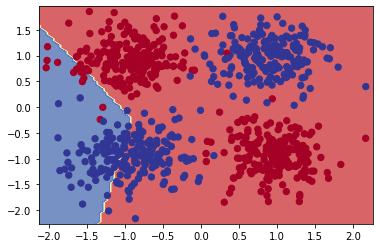

In [11]:
plot_decision_boundary(model, X_train, y_train)

In [11]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=1)
xor = XORDataModule()
trainer.validate(model,xor)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


NameError: ignored

### `forward()`

The `forward()` method applies the neural network to the provided feature vectors. Here we see that the data is first passed through `layer_1`, then through the ReLU activations that then pass through `layer_2`.

In [ ]:
from sklearn.metrics import accuracy_score

with torch.inference_mode(): 
    predictions = model(X_test)

predictions = torch.squeeze(torch.round(torch.sigmoid(predictions)))
predictions = predictions.detach().numpy()

print("test set accuracy: {}".format(accuracy_score(y_test,predictions)))

test set accuracy: 0.52


## Training the model

We use `BCEWithLogitsLoss` as the loss function and SGD, `torch.optim.SGD(params, lr)` as the optimizer.

In [ ]:
learning_rate = 0.005

#the loss function
loss_func = torch.nn.BCEWithLogitsLoss()

#the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now we can create and run our training and validation loop.



training loss: 0.7200626134872437
validation accuracy: 0.6


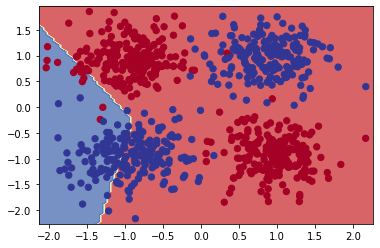

training loss: 0.6523182392120361
validation accuracy: 0.61


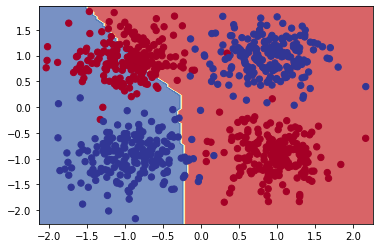

training loss: 0.608246922492981
validation accuracy: 0.6


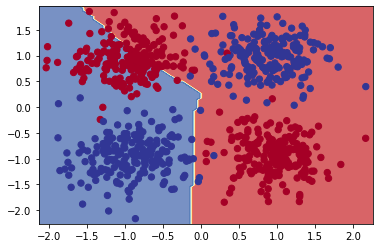

training loss: 0.5621764659881592
validation accuracy: 0.65


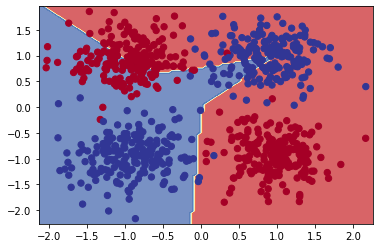

training loss: 0.5165428519248962
validation accuracy: 0.82


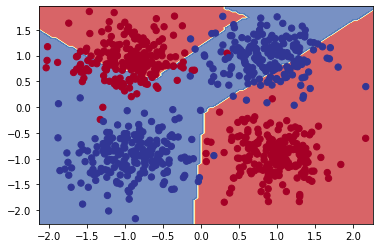

training loss: 0.47056180238723755
validation accuracy: 0.88


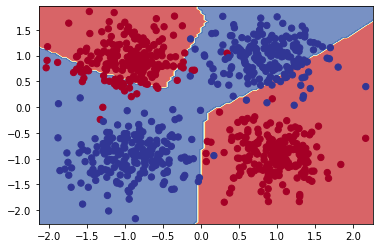

training loss: 0.4203900992870331
validation accuracy: 0.91


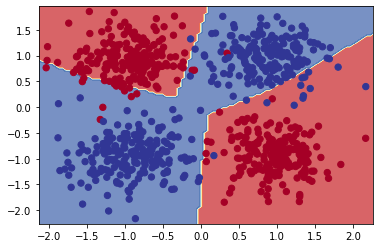

training loss: 0.36573660373687744
validation accuracy: 0.96


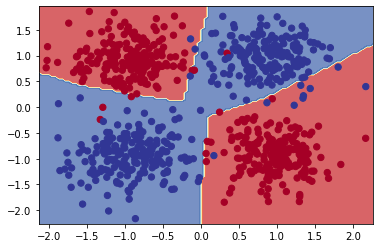

training loss: 0.3104765713214874
validation accuracy: 0.96


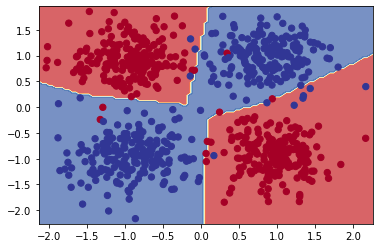

training loss: 0.26015859842300415
validation accuracy: 0.97


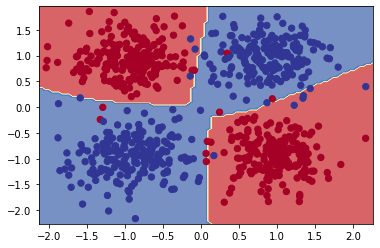

training loss: 0.21756507456302643
validation accuracy: 0.97


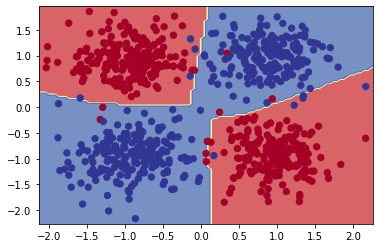

training loss: 0.1841445118188858
validation accuracy: 0.97


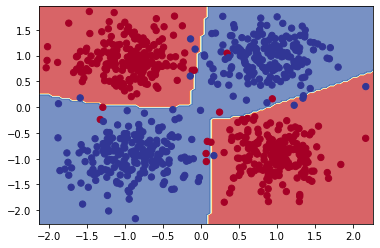

training loss: 0.1584366410970688
validation accuracy: 0.98


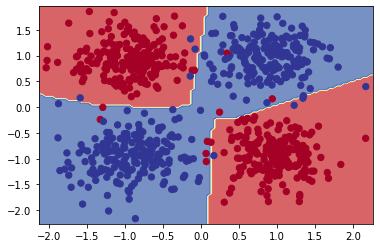

training loss: 0.1389921009540558
validation accuracy: 0.98


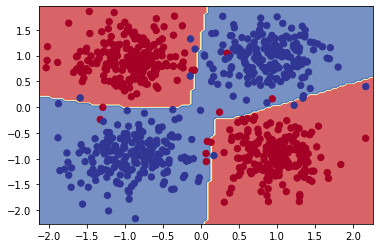

training loss: 0.1238783746957779
validation accuracy: 0.98


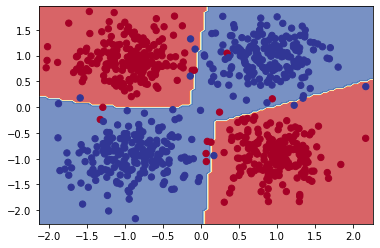

training loss: 0.11188086867332458
validation accuracy: 0.98


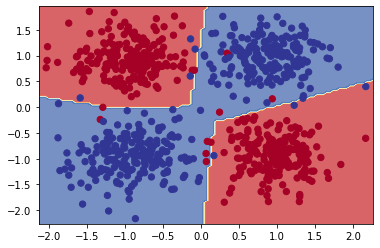

In [ ]:
#number of times we iterate trough the train set
num_epochs = 8000

for epoch in range(num_epochs):

    #step 1
    predictions_train = torch.squeeze(model(X_train)) 

    #step 2
    loss = loss_func(predictions_train, y_train) 

    #step 3
    optimizer.zero_grad() 

    #step 4
    loss.backward() 

    #step 5
    optimizer.step() 
        
    if epoch % 500 == 0:    
      print("training loss: {}".format(loss))    
      model.eval()
      with torch.inference_mode(): 
        predictions_val = torch.squeeze(torch.round(torch.sigmoid(model(X_val)))).detach().numpy()
        print("validation accuracy: {}".format(accuracy_score(y_val,predictions_val)))
      model.train()
      plot_decision_boundary(model, X_train, y_train)
      plt.show()


## Computing predictions and evaluating the model


In [ ]:
model.eval()

with torch.inference_mode(): 
    predictions_test = model(X_test)

predictions_test = torch.round(torch.sigmoid(torch.squeeze(predictions_test))).detach().numpy()

print("test set accuracy: {}".format(accuracy_score(y_test,predictions_test)))

test set accuracy: 0.97


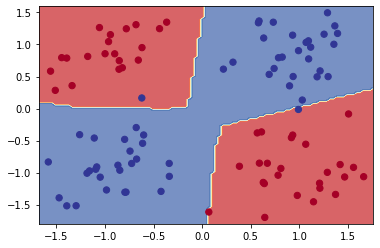

In [ ]:
plot_decision_boundary(model, X_test, y_test)